
# Min Graph Coloring Problem



## Background

Given a graph $G = (V,E)$, find the minimal number of colors k required to properly color it.
A coloring is legal if:

- each vetrex ${v_i}$ is assigned with a color $k_i \in \{0, 1, ..., k-1\}$
- adajecnt vertex have different colors: for each $v_i, v_j$ such that $(v_i, v_j) \in E$, $k_i \neq k_j$.
A graph which is k-colorable but not (k−1)-colorable is said to have chromatic number k. The maximum bound on the chromatic number is $D_G + 1$, where $D_G$ is the maximum vertex degree. The graph coloring problem is known to be in the NP-hard complexity class.

## Solving the problem with classiq



### Define the optimization problem


We encode the graph coloring with a matrix of variables `X` with dimensions $k \times |V|$ using one-hot encoding, such that a $X_{ki} = 1$ means that vertex i is colored by color k.

We require that each vertex is colored by exactly one color and that 2 adjacent vertices have different colors.

In [19]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_min_graph_coloring_model(graph, max_num_colors):
    model = pyo.ConcreteModel()

    nodes = list(graph.nodes())
    colors = range(0, max_num_colors)

    model.x = pyo.Var(colors, nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    adjacency_matrix_block_diagonal = np.kron(np.eye(degree_max), adjacency_matrix)

    model.conflicting_color_constraint = pyo.Constraint(
        expr=x_variables @ adjacency_matrix_block_diagonal @ x_variables == 0
    )

    @model.Constraint(nodes)
    def each_vertex_is_colored(model, node):
        return sum(model.x[color, node] for color in colors) == 1

    def is_color_used(color):
        is_color_not_used = np.prod([(1 - model.x[color, node]) for node in nodes])
        return 1 - is_color_not_used

    # minimize the number of colors in use
    model.value = pyo.Objective(
        expr=sum(is_color_used(color) for color in colors), sense=pyo.minimize
    )

    return model

### Initialize the model with example graph

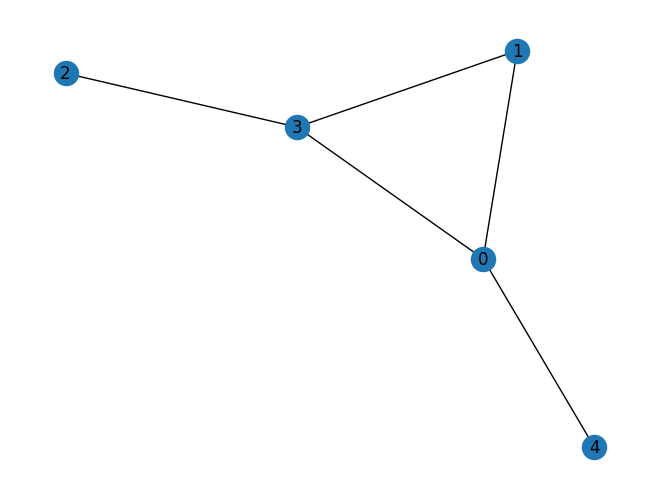

In [20]:
graph = nx.erdos_renyi_graph(5, 0.3, seed=79)
nx.draw_kamada_kawai(graph, with_labels=True)

degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
degree_max = max(degree_sequence)
max_num_colors = degree_max

coloring_model = define_min_graph_coloring_model(graph, max_num_colors)

### show the resulting pyomo model

In [21]:
coloring_model.pprint()

4 Set Declarations
    each_vertex_is_colored_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   15 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}

1 Var Declarations
    x : Size=15, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : 

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlates the pyomo model to a quantum model of the qaoa algorithm, with cost hamiltonian translated from the pyomo model. We can choose the number of layers for the qaoa ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [23]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=coloring_model, num_layers=6, penalty_factor=10)

qmod = combi.get_model()

In [24]:
write_qmod(qmod, "min_graph_coloring")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [25]:
qprog = combi.get_qprog()
show(qprog)

ClassiqAPIError: Internal error occurred. Please contact Classiq support.
Error number 122001 occurred:

Error identifier: EE2BDCFA1-76C0-4282-A217-1E566BB5B8CC
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

We also set the quantum backend we want to execute on:

In [ ]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[2](#cvar)]:

In [13]:
cost_values = []
optimized_params = combi.optimize(
    execution_preferences, maxiter=70, cost_trace=cost_values, quantile=0.3
)

# Optimization Results

We can also examine the statistics of the algorithm. In order to get samples with the optimized parameters, we call the `get_results` method:

In [9]:
optimization_result = combi.get_results()
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
96,"{'x_0': 1, 'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4'...",0.001953,-4.0
108,"{'x_0': 0, 'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4'...",0.000977,-4.0
52,"{'x_0': 1, 'x_1': 1, 'x_2': 0, 'x_3': 0, 'x_4'...",0.007812,-3.0
28,"{'x_0': 0, 'x_1': 1, 'x_2': 0, 'x_3': 1, 'x_4'...",0.011230,-3.0
32,"{'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_3': 1, 'x_4'...",0.010254,-3.0


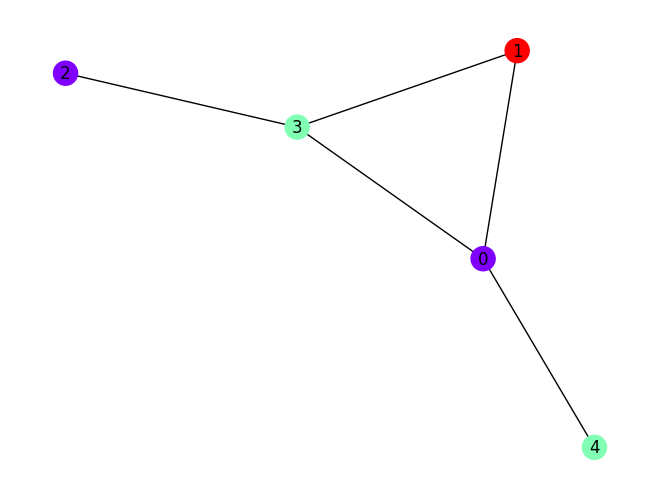

In [14]:
import matplotlib.pyplot as plt

best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution = [best_solution[f"x_{v}"] for v in range(len(best_solution))]

one_hot_solution = np.array(best_solution).reshape([max_num_colors, len(graph.nodes)])
integer_solution = np.argmax(one_hot_solution, axis=0)
nx.draw_kamada_kawai(
    graph, with_labels=True, node_color=integer_solution, cmap=plt.cm.rainbow
)

And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

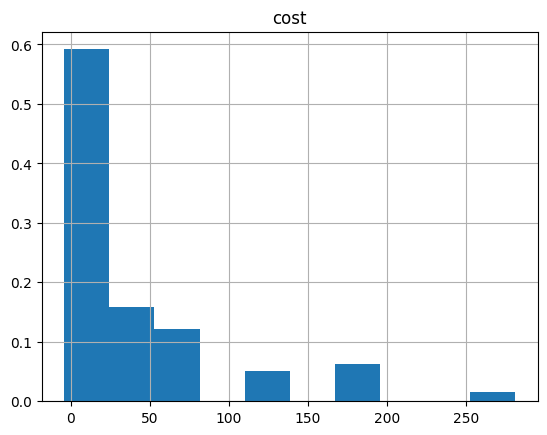

In [10]:
optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [11]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x_0': 1, 'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4': 0, 'x_5': 0, 'x_6': 0}

## Classical optimizer results

Lastly, we can compare to the classical solution of the problem:

In [15]:
from pyomo.common.errors import ApplicationError
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
result = None
try:
    result = solver.solve(coloring_model)
except ApplicationError:
    print("Solver might have not exited normally. Try again")

coloring_model.display()

ERROR: Solver (asl) returned non-zero return code (-11)


ERROR: Solver log: Couenne 0.5.8 -- an Open-Source solver for Mixed Integer
    Nonlinear Optimization Mailing list: couenne@list.coin-or.org
    Instructions: http://www.coin-or.org/Couenne couenne:


Solver might have not exited normally. Try again
Model unknown

  Variables:
    x : Size=15, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary
        (1, 3) :     0 :  None :     1 : False :  True : Binary
        (1, 4) :     0 :  None :     1 : False :  True : Binary
        (2, 0) :     0 :  None :     1 : False :  True : Binary
        (2, 1) :     0 :  None :     1 : False :  True : Binary
        (2, 2) :     0 :  None :     1 : False :  True : Bin

ERROR: evaluating object as numeric value: value
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object x[0,0]


        Key : Active : Value
        None :   None :  None

  Constraints:
    conflicting_color_constraint : Size=1
        Key  : Lower : Body : Upper
        None :   0.0 : None :   0.0
    each_vertex_is_colored : Size=5
        Key : Lower : Body : Upper
          0 :   1.0 : None :   1.0
          1 :   1.0 : None :   1.0
          2 :   1.0 : None :   1.0
          3 :   1.0 : None :   1.0
          4 :   1.0 : None :   1.0


In [16]:
if result:
    classical_solution = [
        pyo.value(coloring_model.x[i, j])
        for i in range(max_num_colors)
        for j in range(len(graph.nodes))
    ]
    one_hot_solution = np.array(classical_solution).reshape(
        [max_num_colors, len(graph.nodes)]
    )
    integer_solution = np.argmax(one_hot_solution, axis=0)
    nx.draw_kamada_kawai(
        graph, with_labels=True, node_color=integer_solution, cmap=plt.cm.rainbow
    )


## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[2]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
